In [1]:
import lib_eval as eval
import pickle as pk
import pandas as pd
import numpy as np
from numpy import *
import time
import matplotlib.pyplot as plt
from tqdm import *
from pylab import *
from multiprocessing import Pool
import pickle
import os
import julian
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
from scipy.stats import multivariate_normal as mn
nasa_julian = 98
cnes_julian = 90
import os
os.environ['PROJ_LIB']= "C:\\Users\\vankh\\Anaconda3\\Lib\\site-packages\\mpl_toolkits\\basemap"
from mpl_toolkits.basemap import Basemap

## I. Predict temperature surface in the Gulf Stream region (pressure < 100)


In [65]:
# Load coordinates, dates
coords_g_train =  pd.read_pickle('data/GS-p_100/feature_train_gs_100.pkl')
lat_train, lon_train, juld_train = coords_g_train[:,0],coords_g_train[:,1],coords_g_train[:,2]
coords_g_test =  pd.read_pickle('data/GS-p_100/feature_test_gs_100.pkl')
lat_test, lon_test, juld_test = coords_g_test[:,0],coords_g_test[:,1],coords_g_test[:,2]
map = Basemap(projection='merc',llcrnrlat=30,urcrnrlat=50,llcrnrlon=-75,urcrnrlon=-35,resolution='c')

In [66]:
# Ground truth surface temperature
gt_temp_train = pd.read_pickle('data/GS-p_100/y_train_gs_100.pkl')[:,0]
gt_temp_test = pd.read_pickle('data/GS-p_100/y_test_gs_100.pkl')[:,0]

In [67]:
# Estimated surface temperature
est_temp_train = np.loadtxt('trained-model/GS-p_100/y_h_train_E1_5.txt')
est_temp_test = np.loadtxt('trained-model/GS-p_100/y_h_test_E1_5.txt')

In [68]:
# Residual plot of temperature
residual_temp_train = est_temp_train-gt_temp_train
residual_temp_test = est_temp_test-gt_temp_test

In [69]:
#### Dominant mode for each profile on the maps
pi_hat_train = np.loadtxt('trained-model/GS-p_100/pi_h_train_E1_5.txt')
pi_hat_test = np.loadtxt('trained-model/GS-p_100/pi_h_test_E1_5.txt')

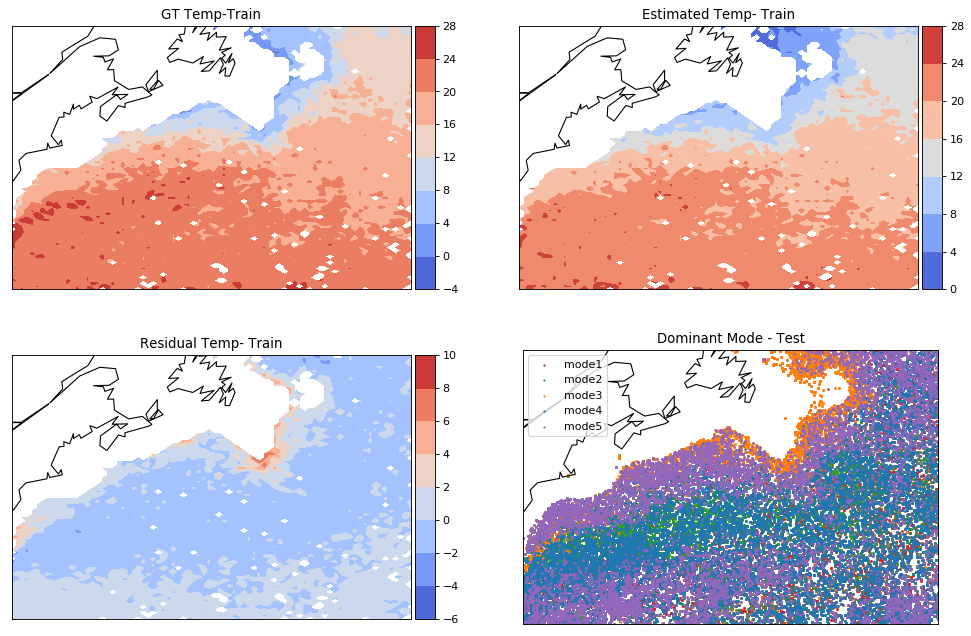

In [7]:
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
eval.pcolor_surface(lon_train, lat_train, 80, 80, map, gt_temp_train, title = 'GT Temp-Train', combine = True ,subplot = 221)
eval.pcolor_surface(lon_train, lat_train, 80, 80, map, est_temp_train, title = 'Estimated Temp- Train', combine = True ,subplot = 222)
eval.pcolor_surface(lon_train, lat_train, 80, 80, map, residual_temp_train, title = 'Residual Temp- Train', combine = True ,subplot = 223)
eval.mode_dist(lon_train, lat_train,map, pi_hat_train, combine = True ,subplot = 224, title = "Dominant Mode - Test")

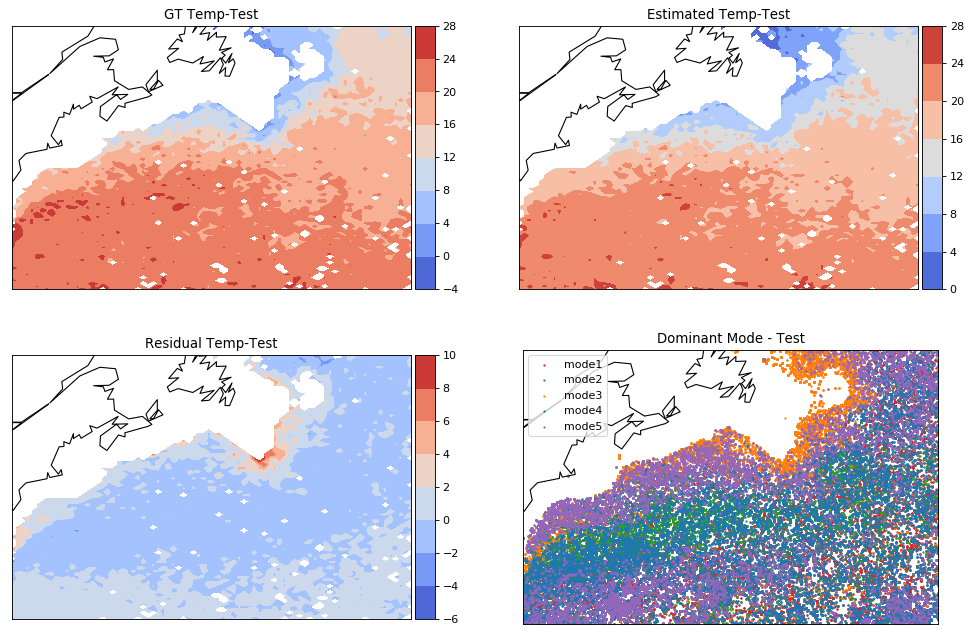

In [8]:
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
eval.pcolor_surface(lon_test, lat_test, 80, 80, map, gt_temp_test, title = 'GT Temp-Test', combine = True ,subplot = 221)
eval.pcolor_surface(lon_test, lat_test, 80, 80, map, est_temp_test, title = 'Estimated Temp-Test', combine = True ,subplot = 222)
eval.pcolor_surface(lon_test, lat_test, 80, 80, map, residual_temp_test, title = 'Residual Temp-Test', combine = True ,subplot = 223)
eval.mode_dist(lon_test, lat_test,map, pi_hat_test, combine = True ,subplot = 224, title = "Dominant Mode - Test")

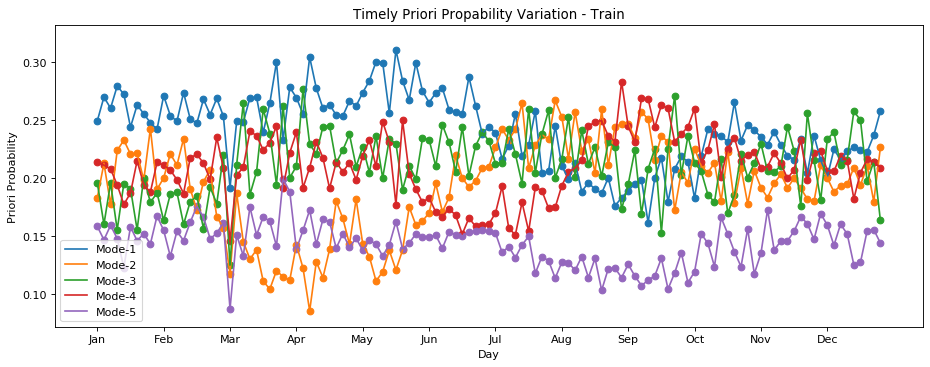

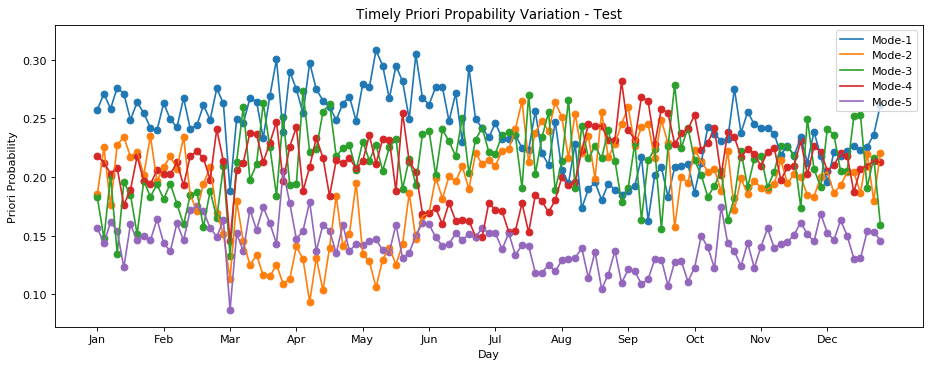

In [11]:
# Plot the prorior mode probabilities varying in time
eval.prior_prob_time_plot(pi_hat_train,juld_train, 5,3,title = "Timely Priori Propability Variation - Train", figx =14, figy = 5)
eval.prior_prob_time_plot(pi_hat_test,juld_test, 5,3,title = "Timely Priori Propability Variation - Test", figx =14, figy = 5)

In [70]:
# Following the temperature evolution
X = pd.read_pickle("data/GS-p_100/x_train_gs_100.pkl")
test_info = pd.read_pickle("trained-model/GS-p_100/E1_info.pkl")
f_x = test_info["feature_mean"]
std_x = test_info["feature_std"]
beta = pd.read_pickle("trained-model/GS-p_100/beta_E1_5.pkl")
lambda_ = pd.read_pickle("trained-model/GS-p_100/lambda_E1_5.pkl")
sigma = pd.read_pickle("trained-model/GS-p_100/sigma_E1_5.pkl")
profiles = pd.read_pickle('data/GS-p_100/feature_train_gs_100.pkl')[:,-1]

Coordinates x:  (longtitude= -67.6259994506836,latitude= 31.516000747680664)


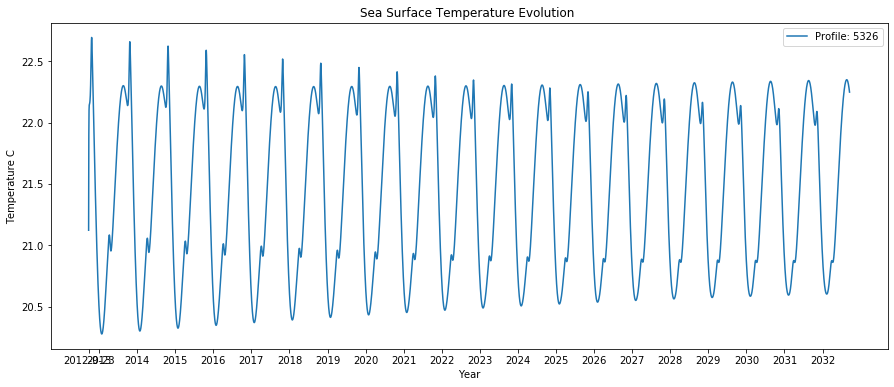

In [71]:
index = 10000
priode_ = 365*20 # days
prof = profiles[index]
daysx,tempx = eval.follow_x(index,coords_g_train,priode_,X,f_x,std_x,pi_hat_train,beta,lambda_,sigma,gt_temp_train)
eval.follow_x_plot(daysx,tempx,int(prof),step = 1)

## II. Predict temperature surface in the KUROSHIO region (pressure < 100, 10% data)

### Load coordinates, dates

In [100]:
# Load coordinates, dates
coords_g_train =  pd.read_pickle('data/KS-p_100-10/feature_train-KS-p_100-10.pkl')
lat_train, lon_train, juld_train = coords_g_train[:,0],coords_g_train[:,1],coords_g_train[:,2]
coords_g_test =  pd.read_pickle('data/KS-p_100-10/feature_test-KS-p_100-10.pkl')
lat_test, lon_test, juld_test = coords_g_test[:,0],coords_g_test[:,1],coords_g_test[:,2]
map = Basemap(projection='merc',llcrnrlat=25,urcrnrlat=45,llcrnrlon=132,urcrnrlon=180,resolution='c')

In [101]:
# Ground truth surface temperature
ks_temp_train = pd.read_pickle('data/KS-p_100-10/y_train-KS-p_100-10.pkl')[:,0]
ks_temp_test = pd.read_pickle('data/KS-p_100-10/y_test-KS-p_100-10.pkl')[:,0]

In [102]:
# Estimated surface temperature
est_temp_train = np.loadtxt('trained-model/KS-p_100-10/y_h_train_E2_5.txt')
est_temp_test = np.loadtxt('trained-model/KS-p_100-10/y_h_test_E2_5.txt')

In [103]:
# Residual plot of temperature
residual_temp_train = est_temp_train-ks_temp_train
residual_temp_test = est_temp_test-ks_temp_test

In [104]:
#### Dominant mode for each profile on the maps
pi_hat_train = np.loadtxt('trained-model/KS-p_100-10/pi_h_train_E2_5.txt')
pi_hat_test = np.loadtxt('trained-model/KS-p_100-10/pi_h_test_E2_5.txt')

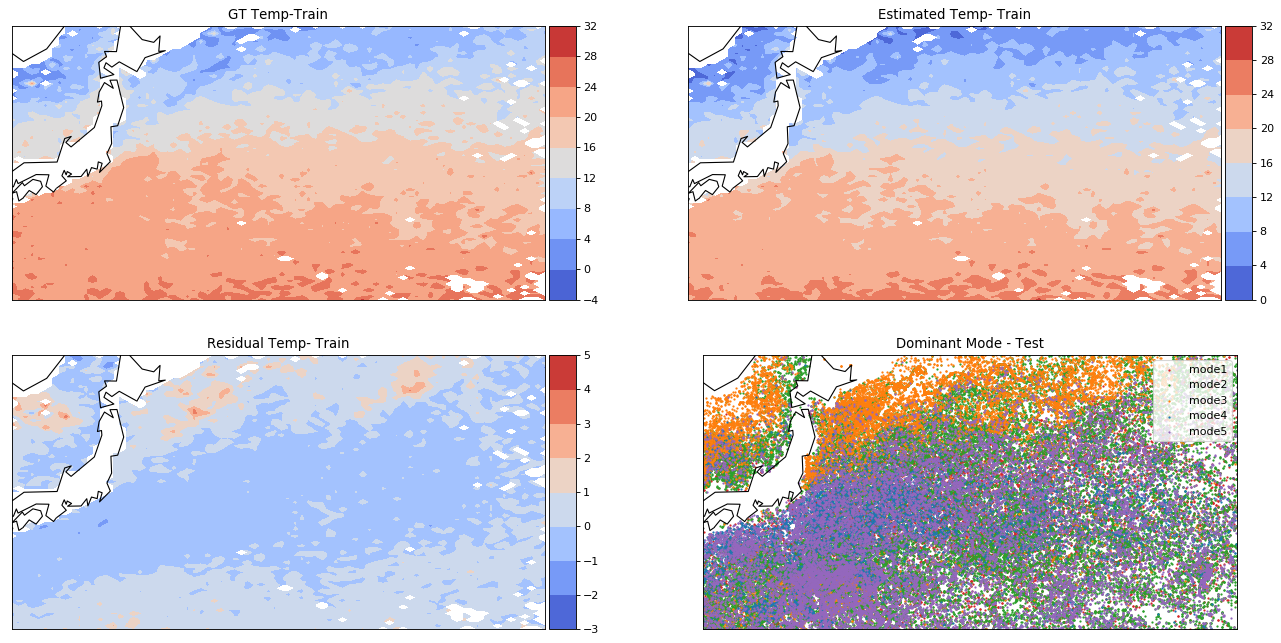

In [90]:
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
eval.pcolor_surface(lon_train, lat_train, 80, 80, map, ks_temp_train, title = 'GT Temp-Train', combine = True ,subplot = 221)
eval.pcolor_surface(lon_train, lat_train, 80, 80, map, est_temp_train, title = 'Estimated Temp- Train', combine = True ,subplot = 222)
eval.pcolor_surface(lon_train, lat_train, 80, 80, map, residual_temp_train, title = 'Residual Temp- Train', combine = True ,subplot = 223)
eval.mode_dist(lon_train, lat_train,map, pi_hat_train, combine = True ,subplot = 224, title = "Dominant Mode - Test")

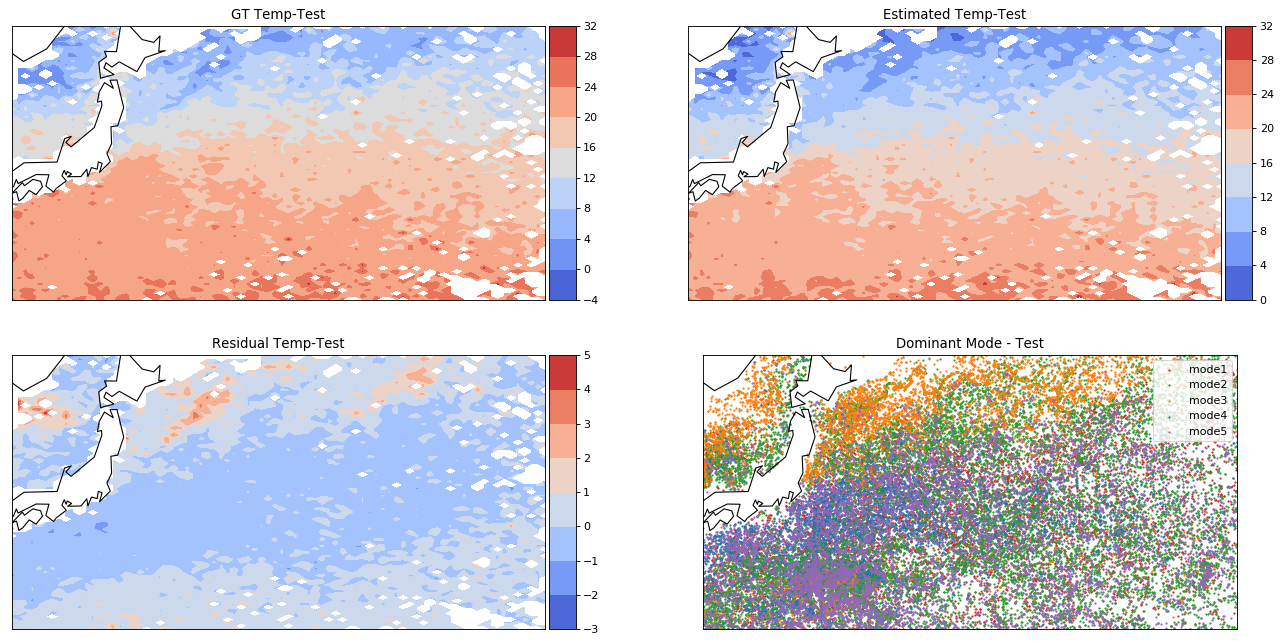

In [91]:
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
eval.pcolor_surface(lon_test, lat_test, 80, 80, map, ks_temp_test, title = 'GT Temp-Test', combine = True ,subplot = 221)
eval.pcolor_surface(lon_test, lat_test, 80, 80, map, est_temp_test, title = 'Estimated Temp-Test', combine = True ,subplot = 222)
eval.pcolor_surface(lon_test, lat_test, 80, 80, map, residual_temp_test, title = 'Residual Temp-Test', combine = True ,subplot = 223)
eval.mode_dist(lon_test, lat_test,map, pi_hat_test, combine = True ,subplot = 224, title = "Dominant Mode - Test")

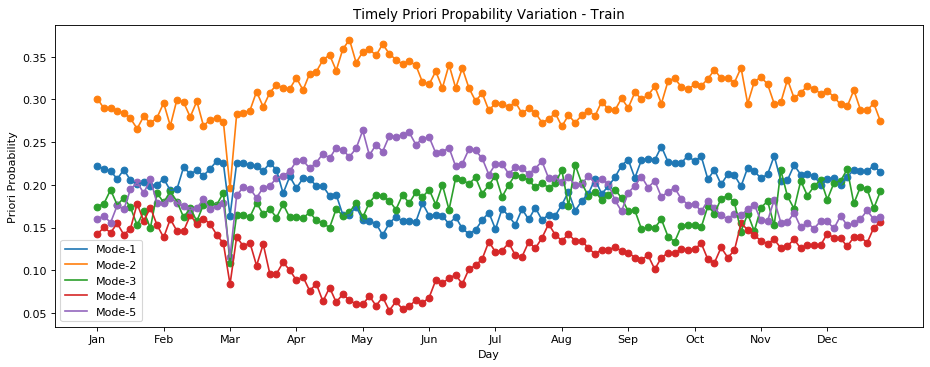

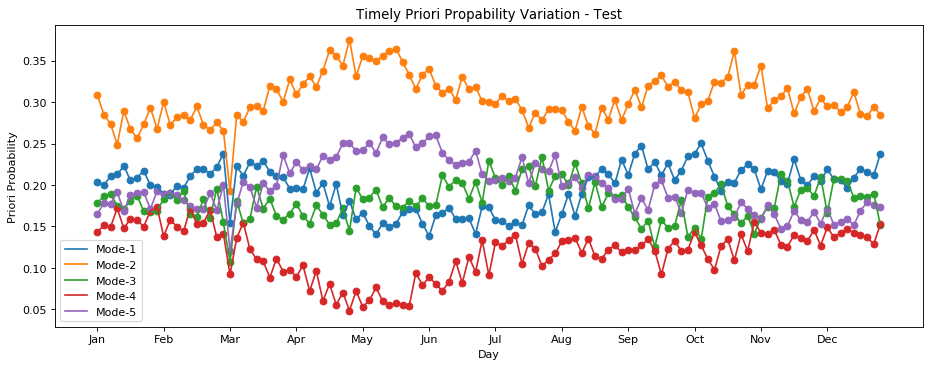

In [92]:
# Plot the prorior mode probabilities varying in time
eval.prior_prob_time_plot(pi_hat_train,juld_train, 5,3,title = "Timely Priori Propability Variation - Train", figx =14, figy = 5)
eval.prior_prob_time_plot(pi_hat_test,juld_test, 5,3,title = "Timely Priori Propability Variation - Test", figx =14, figy = 5)

In [105]:
# Following the temperature evolution
X = pd.read_pickle("data/KS-p_100-10/x_train-KS-p_100-10.pkl")
test_info = pd.read_pickle("trained-model/KS-p_100-10/E2_info.pkl")
f_x = test_info["feature_mean"]
std_x = test_info["feature_std"]
beta = pd.read_pickle("trained-model/KS-p_100-10/beta_E2_5.pkl")
lambda_ = pd.read_pickle("trained-model/KS-p_100-10/lambda_E2_5.pkl")
sigma = pd.read_pickle("trained-model/KS-p_100-10/sigma_E2_5.pkl")
profiles = pd.read_pickle('data/KS-p_100-10/feature_train-KS-p_100-10.pkl')[:,-1]

Coordinates x:  (longtitude= 143.53195190429688,latitude= 28.477210998535156)


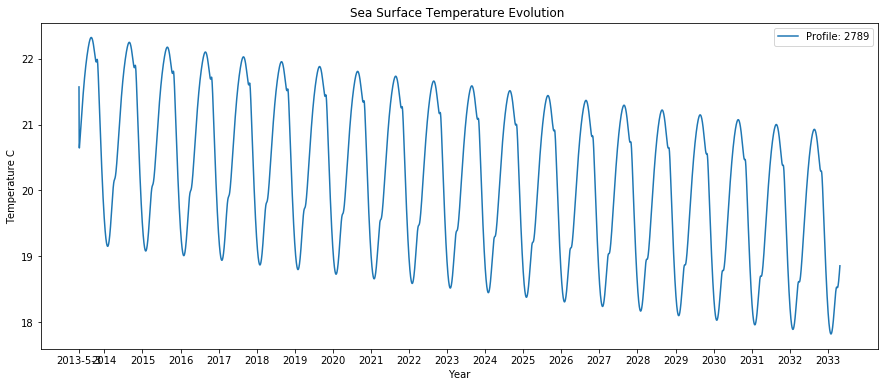

In [106]:
index = 50000
priode_ = 365*20 # days
prof = profiles[index]
daysx,tempx = eval.follow_x(index,coords_g_train,priode_,X,f_x,std_x,pi_hat_train,beta,lambda_,sigma,gt_temp_train)
eval.follow_x_plot(daysx,tempx,int(prof),step = 1)

### Extract and plot a temperature profile evolution in time

In [82]:
# p =  profiles2[np.random.randint(0,len(profiles2),1)][0]
p = 2468
mask_p = np.where(profiles2.astype(int) == p)
julian_p = julian2[mask_p]
temp_p = gt_temp2[mask_p]
x_p = X2[mask_p,:][0,:,:]

In [164]:
sorted_time_index = np.argsort(julian_p)
sorted_time = julian_p[sorted_time_index]
sorted_temp = temp_p[sorted_time_index]

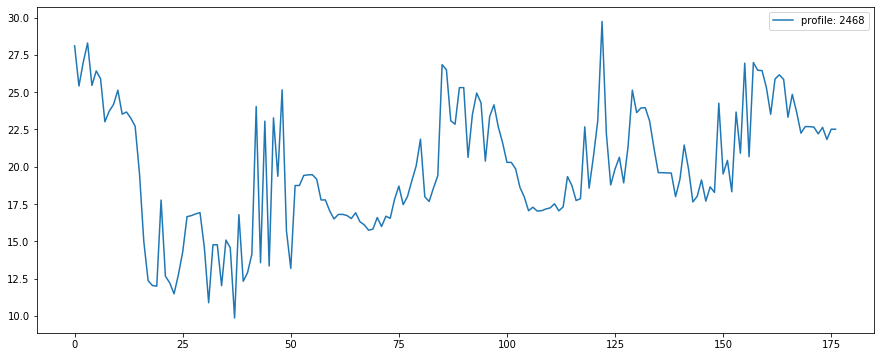

In [165]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(sorted_temp, label = "profile: "+str(int(p)))
plt.legend()
plt.show()